In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics
import numpy as np

In [2]:
!ls

data  gnn.ipynb  log  ngrok  ngrok-stable-linux-amd64.zip  poc.py


In [3]:
#!pip3 show torch
print(torch.cuda.is_available())


True


In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [3]:
import networkx as nx


1


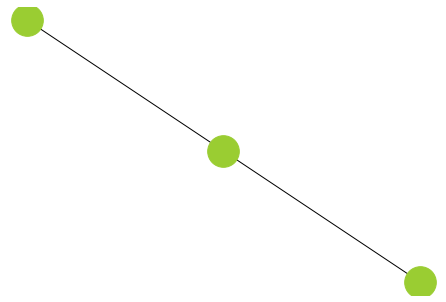

In [4]:
import torch
from torch_geometric.data import Data
import torch_geometric

edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), directed=True)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g, font_size=15, withlabels=True,
        node_color='yellowgreen', node_size=1000 )

print(data.num_node_features
)

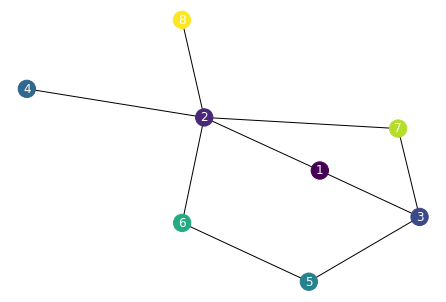

In [9]:
import matplotlib.pyplot as plt
G = nx.Graph()
G.add_edges_from(
    [('1', '2'), ('1', '3'), ('4', '2'), ('5', '3'), ('5', '6'),
     ('2', '8'), ('2', '7'), ('2', '6'), ('3', '7')])

val_map = {'1': 0.0,
           '2': 0.1,
           '3': 0.2,
           '4': 0.3,
           '5': 0.4,
           '6': 0.55,
           '7': 0.8,
           '8': 0.9}

values = [val_map.get(node, 0.25) for node in G.nodes()]

nx.draw(G, cmap=plt.get_cmap('viridis'), node_color=values, with_labels=True, font_color='white')
plt.show()

4

In [9]:
device = torch.device('cuda')
data = data.to(device)


In [10]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

In [11]:
dataset?

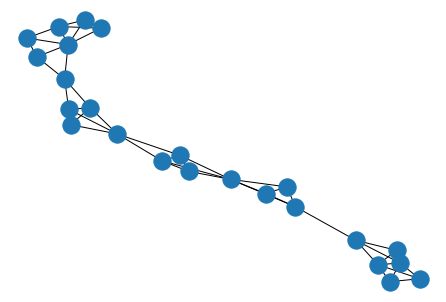

In [12]:
g = torch_geometric.utils.to_networkx(dataset[5], to_undirected=True)
nx.draw(g)

In [13]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)    

In [14]:
for batch in loader:
    print(batch)
    print(batch.num_graphs)


DataBatch(edge_index=[2, 4106], x=[1076, 21], y=[32], batch=[1076], ptr=[33])
32
DataBatch(edge_index=[2, 3894], x=[990, 21], y=[32], batch=[990], ptr=[33])
32
DataBatch(edge_index=[2, 3734], x=[962, 21], y=[32], batch=[962], ptr=[33])
32
DataBatch(edge_index=[2, 4240], x=[1094, 21], y=[32], batch=[1094], ptr=[33])
32
DataBatch(edge_index=[2, 3582], x=[922, 21], y=[32], batch=[922], ptr=[33])
32
DataBatch(edge_index=[2, 3886], x=[1042, 21], y=[32], batch=[1042], ptr=[33])
32
DataBatch(edge_index=[2, 4168], x=[1164, 21], y=[32], batch=[1164], ptr=[33])
32
DataBatch(edge_index=[2, 3966], x=[1020, 21], y=[32], batch=[1020], ptr=[33])
32
DataBatch(edge_index=[2, 4138], x=[1077, 21], y=[32], batch=[1077], ptr=[33])
32
DataBatch(edge_index=[2, 4330], x=[1085, 21], y=[32], batch=[1085], ptr=[33])
32
DataBatch(edge_index=[2, 4030], x=[1104, 21], y=[32], batch=[1104], ptr=[33])
32
DataBatch(edge_index=[2, 4222], x=[1168, 21], y=[32], batch=[1168], ptr=[33])
32
DataBatch(edge_index=[2, 3852], x=

In [6]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

In [7]:
torch_geometric.utils.to_networkx?

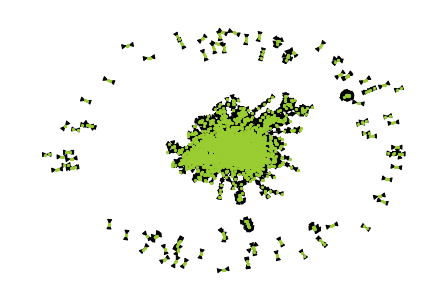

In [10]:
g = torch_geometric.utils.to_networkx(dataset[0])
nx.draw(g, node_color='yellowgreen', node_size=5)

In [50]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

dropout = 0.2
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 128)
        self.conv5 = GCNConv(128, 256)
        self.conv6 = GCNConv(256, dataset.num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=dropout,training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=dropout,training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=dropout,training=self.training)
        
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=dropout,training=self.training)
        
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=dropout,training=self.training)
        
        x = self.conv6(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.003)

model.train()
for epoch in range(500):
    print("-------------Epoch number ", str(epoch))
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


-------------Epoch number  0
-------------Epoch number  1
-------------Epoch number  2
-------------Epoch number  3
-------------Epoch number  4
-------------Epoch number  5
-------------Epoch number  6
-------------Epoch number  7
-------------Epoch number  8
-------------Epoch number  9
-------------Epoch number  10
-------------Epoch number  11
-------------Epoch number  12
-------------Epoch number  13
-------------Epoch number  14
-------------Epoch number  15
-------------Epoch number  16
-------------Epoch number  17
-------------Epoch number  18
-------------Epoch number  19
-------------Epoch number  20
-------------Epoch number  21
-------------Epoch number  22
-------------Epoch number  23
-------------Epoch number  24
-------------Epoch number  25
-------------Epoch number  26
-------------Epoch number  27
-------------Epoch number  28
-------------Epoch number  29
-------------Epoch number  30
-------------Epoch number  31
-------------Epoch number  32
-------------Epoch n

-------------Epoch number  288
-------------Epoch number  289
-------------Epoch number  290
-------------Epoch number  291
-------------Epoch number  292
-------------Epoch number  293
-------------Epoch number  294
-------------Epoch number  295
-------------Epoch number  296
-------------Epoch number  297
-------------Epoch number  298
-------------Epoch number  299
-------------Epoch number  300
-------------Epoch number  301
-------------Epoch number  302
-------------Epoch number  303
-------------Epoch number  304
-------------Epoch number  305
-------------Epoch number  306
-------------Epoch number  307
-------------Epoch number  308
-------------Epoch number  309
-------------Epoch number  310
-------------Epoch number  311
-------------Epoch number  312
-------------Epoch number  313
-------------Epoch number  314
-------------Epoch number  315
-------------Epoch number  316
-------------Epoch number  317
-------------Epoch number  318
-------------Epoch number  319
--------

In [66]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7470


tensor([3, 4, 4,  ..., 0, 3, 3], device='cuda:0')


In [24]:
dataset.num_classes

7

In [25]:
L = [0]*7
for p in pred:
    L[p] += 1

In [26]:
print(L)

[363, 248, 426, 712, 470, 256, 233]


In [67]:
data=dataset[0]
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False


/cluster/home/louisgu/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/cluster/home/louisgu/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


Is undirected: True
